<a href="https://colab.research.google.com/github/minnji88/DeepLearning2020/blob/master/6_3_%EC%88%9C%ED%99%98_%EC%8B%A0%EA%B2%BD%EB%A7%9D%EC%9D%98_%EA%B3%A0%EA%B8%89_%EC%82%AC%EC%9A%A9%EB%B2%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

기법들은 다음과 같습니다.
1. 순환 드롭아웃(recurrent dropout) : 순환 층에서 과대적합을 방지하기 위해 케라스에 내장되어 있는 드롭아웃을 사용
2. 스태킹 순환 층(stacking recurrent layer) : 네트워크의 표현 능력(representation power)을 증가 - 대신 계산 비용이 많이듬
3. 양방향 순환 층(bidirectional recurrent layer) : 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지시킵니다.


##6.3.1 기온 예측 문제

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 코드 6-28 예나의 날씨 데이터셋 조사하기

import os

data_dir = '/content/drive/My Drive/COLAB/SAI/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


420,551개 데이터 전체를 넘파이 배열로 바꿉니다:

In [5]:
# 코드 6-29 데이터 파싱하기
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i,:] = values

예를 들어 다음은 시간에 따른 기온(섭씨) 그래프입니다:

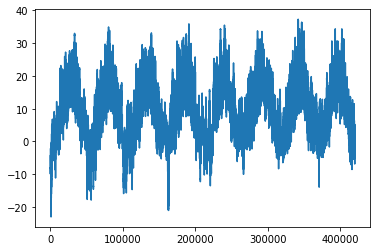

In [6]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # 온도(섭씨)
plt.plot(range(len(temp)), temp)
plt.show()

이 그래프에서 온도에 주기성이 있다는 것을 잘 볼 수 있습니다.

다음은 기간을 좁혀서 처음 10일간의 온도 데이터를 나타낸 그래프입니다. 10분마다 데이터가 기록되므로 하루에 총 144개의 데이터 포인트가 있습니다:

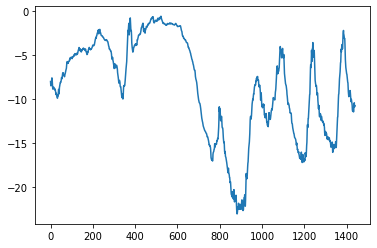

In [7]:
plt.plot(range(1440), temp[:1440])
plt.show()

이 그래프에서 일별 주기성을 볼 수 있습니다. 특히 마지막 4일간을 보면 확실합니다. 이 데이터는 아주 추운 겨울 중 10일입니다.

지난 몇 달간의 데이터를 사용해 다음 달의 평균 온도를 예측하는 문제는 쉬운 편입니다. 연간 데이터 주기성은 안정적이기 때문입니다. 하지만 하루 하루 데이터를 살펴보면 온도 변화는 매우 불안정합니다. 일자별 수준의 시계열 데이터를 예측할 수 있을까요? 직접 확인해 보겠습니다.

## 6.3.2 데이터 준비
사용할 변수는 다음과 같습니다.
- lookback = 1440 : 10일 전 데이터로 돌아갑니다.
- steps = 6 : 한 시간마다 데이터 포인트 하나를 샘플링합니다.
- delay = 144 : 24시간이 지난 데이터가 타깃이 됩니다.

신경망에 주입할 수 있는 형태로 데이터를 전처리합니다. 데이터가 이미 수치형이므로 추가적인 벡터화가 필요하지 않습니다. 하지만 데이터에 있는 각 시계열 특성의 범위가 서로 다릅니다(예를 들어 온도는 일반적으로 -20도에서 +30도 사이이고, 밀리바(mb)로 측정된 기압은 1,000 근처의 값입니다). 각 시계열 특성을 개별적으로 정규화하여 비슷한 범위를 가진 작은 값으로 바꾸겠습니다.
float_data 배열을 받아 과거 데이터의 배치와 미래 타깃 온도를 추출하는 파이썬 제너레이터를 만듭니다. 이 데이터셋에 있는 샘플은 중복이 많습니다(샘플 N과 샘플 N + 1은 대부분 타임스텝이 비슷합니다). 모든 샘플을 각기 메모리에 적재하는 것은 낭비가 심하므로 대신에 원본 데이터를 사용해 그때 그때 배치를 만들겠습니다.

각 시계열 특성에 대해 평균을 빼고 표준 편차로 나누어 전처리합니다. 처음 200,000개 타임스텝을 훈련 데이터로 사용할 것이므로 전체 데이터에서 200,000개만 사용하여 평균과 표준 편차를 계산합니다:

In [12]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

제너레이터 함수는 (samples, targets) 튜플을 반복적으로 반환합니다. 각각은 입력 데이터로 사용할 배치와 이에 대응되는 타깃의 온도의 배열입니다. 다음과 같은 매개변수를 가집니다.

- data : 정규화를 진행한 부동 소수 데이터로 이루어진 원본 배열
- lookback : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
- delay : 타깃으로 사용할 미래의 타임스텝
- min_index와 max_index : 추출할 타임스텝의 범위를 지정하기 위한 data 배열의 인덱스, 검증 데이터와 테스트 데이터를 분리하는 데 사용
- shuffle : 샘플을 섞을지, 시간 순서대로 추출할지 결정
- batch_size : 배치의 샘플 수
- step : 테이터를 샘플링할 타임스텝 간격. 1시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정

In [13]:
# 코드 6-33 시계열 데이터와 타깃을 반환하는 제너레이터 함수

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [14]:
# 코드 6-34 훈련, 검증, 테스트 제너레이터 준비하기
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## 6.3.3 상식 수준의 기준점

이 온도 시계열 데이터는 연속성이 있고 일자별로 주기성을 가지므로 24시간 후 온도는 지금과 동일하다고 예측할 수 있습니다. 이 방법을 평균 절댓값 오차(MAE)로 평가해 보겠습니다.

In [15]:
# 코드 6-35 상식적인 기준 모델의 MAE 계산하기

def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.2897359729905486


다음 코드에서 출력된 값은 0.29 입니다. 이 온도 데이터는 평균이 0이고 표준 편차가 1이므로 결과값의 의미를 파악하기는 어렵습니다. 평균 절댓값 오차에 표준 편차를 곱하면 알 수 있습니다.

In [16]:
# 코드 6-36 MAE 섭씨 단위로 변환하기

0.29 * std[1]

2.5672247338393395

## 6.3.4 기본적인 머신 러닝 방법

In [17]:
# 코드 6-37 완전 연결 모델을 훈련하고 평가하기

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 13s 22ms/step - loss: 1.6299 - val_loss: 0.5205
Epoch 2/20
500/500 [==============================] - 11s 21ms/step - loss: 0.4446 - val_loss: 0.3042
Epoch 3/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2942 - val_loss: 0.3043
Epoch 4/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2650 - val_loss: 0.3391
Epoch 5/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2550 - val_loss: 0.3196
Epoch 6/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2433 - val_loss: 0.2999
Epoch 7/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2389 - val_loss: 0.3288
Epoch 8/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2328 - val_loss: 0.3317
Epoch 9/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2276 - val_loss: 0.3092
Epoch 10/20
500/500 [==============================] - 11s 21ms/step - loss: 0.221

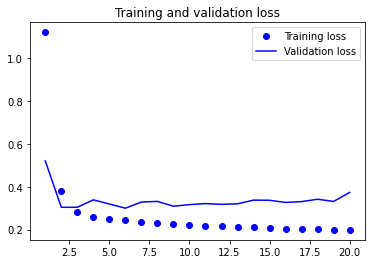

In [18]:
# 코드 6-38 결과 그래프 그리기
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

왜 상식 수준보다 훈련된 모델이 성능이 낮을까요? 그 이유는 훈련 과정이 찾는 것은 간단한 모델이 아니기 때문입니다. 현재 훈련으로 학습된 모델은 매개변수로 설정한 2개의 층을 가진 네트워크의 모든 가능한 가중치 조합입니다. 복잡한 모델 공간에서 해결책을 탐색할 때 간단하고 괜찮은 성능을 내는 모델은 찾지 못할 수 있는 것입니다. 이것이 머신 러닝이 가진 심각한 제약 사항입니다.

## 6.3.5 첫 번째 순환 신경망

첫 번째 완전 연결 네트워크는 실패입니다. 앞선 모델은 시계열 데이터를 펼쳐 시간 개념을 활용할 수 없었습니다. 이제 순서의 의미가 있는 시퀀스 데이터를 그대로 사용해보겠습니다.

이전 절에서 소개한 LSTM이 아닌 GRU 층을 사용합니다. GRU층은 LSTM과 같은 원리로 작동하지만 조금 간결하고, 계산 비용이 덜 듭니다.
대신 학습 능력이 비교적 부족할 수는 있습니다.

In [19]:
# 코드 6-39 GRU를 사용한 모델을 훈련하고 평가하기
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 21s 31ms/step - loss: 0.3664 - val_loss: 0.2733
Epoch 2/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2877 - val_loss: 0.2653
Epoch 3/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2822 - val_loss: 0.2619
Epoch 4/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2757 - val_loss: 0.2613
Epoch 5/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2741 - val_loss: 0.2649
Epoch 6/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2670 - val_loss: 0.2657
Epoch 7/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2630 - val_loss: 0.2664
Epoch 8/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2577 - val_loss: 0.2716
Epoch 9/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2536 - val_loss: 0.2725
Epoch 10/20
500/500 [==============================] - 15s 30ms/step - loss: 0.249

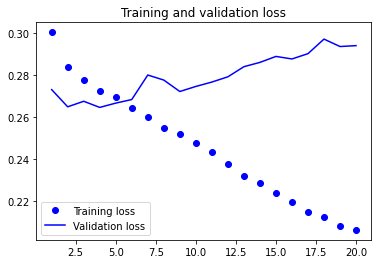

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

훨씬 좋군요! 상식 수준의 모델을 크게 앞질렀습니다. 이 그림은 시퀀스를 펼쳐서 처리하는 완전 연결 네트워크에 비해서 순환 네트워크가 이런 종류의 작업에 훨씬 뛰어나다는 것과 머신 러닝의 가치를 보여줍니다.

새로운 검증 MAE는 0.265 이하(크게 과대적합되기 시작하는 곳)이고 정규화되기 전인 섭씨로 복원하면 MAE는 2.35°C입니다. 초기 에러 2.57°C보다는 확실히 낫지만 더 개선할 수 있을 것 같습니다.

## 6.3.6 과대적합을 감소하기 위해 순환 드롭아웃 사용하기

케라스에서는recurrent_dropout을 이용하여 순환 드롭아웃을 적용할 수 있습니다. 드롭아웃을 하게되면 완전히 수렴하는데 더 오래걸리므로 에포크 수를 2배로 늘립니다.

In [20]:
# 코드 6-40 드롭아웃 규제된 GRU를 사용한 모델을 훈련하고 평가하기
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 403s 803ms/step - loss: 0.3539 - val_loss: 0.2769
Epoch 2/40
500/500 [==============================] - 401s 802ms/step - loss: 0.3073 - val_loss: 0.2730
Epoch 3/40
500/500 [==============================] - 400s 801ms/step - loss: 0.2993 - val_loss: 0.2723
Epoch 4/40
500/500 [==============================] - 400s 800ms/step - loss: 0.2939 - val_loss: 0.2765
Epoch 5/40
500/500 [==============================] - 399s 798ms/step - loss: 0.2871 - val_loss: 0.2770
Epoch 6/40
500/500 [==============================] - 401s 802ms/step - loss: 0.2834 - val_loss: 0.2724
Epoch 7/40
500/500 [==============================] - 400s 801ms/step - loss: 0.2809 - val_loss: 0.2884
Epoch 8/40
500/500 [==============================] - 400s 800ms/step - loss: 0.2775 - val_loss: 0.2760
Epoch 9/40
500/500 [==============================] - 402s 804ms/step - loss: 0.2755 - val_loss: 0.2715
Epoch 10/40
500/500 [==============================] - 399s 798ms/step - lo

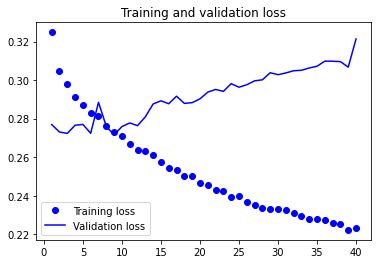

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

층을 추가하여 성능을 조금 향상시켰지만 크지는 않습니다. 여기서 두 가지 결론을 얻을 수 있습니다:

아직 충분히 과대적합을 만들지 못했기 때문에 검증 손실을 향상하기 위해서 층의 크기를 늘릴 수 있습니다. 하지만 적지 않은 계산 비용이 추가됩니다.
층을 추가한 만큼 도움이 되지 않았으므로 여기서는 네트워크의 용량을 늘리는 것이 도움이 되지 않는다고 볼 수 있습니다.

## 6.3.8 양방향 RNN 사용하기

RNN은 순서 또는 시간에 민감합니다. 타임스텝을 섞거나 거꾸로 하면 RNN이 시퀀스에서 학습하는 표현을 완전히 바꾸어버립니다. 양방향 RNN은 RNN이 순서에 민감하다는 성질을 사용합니다. GRU나 LSTM 같은 RNN을 2개 사용합니다. 각 RNN은 각 입력을 한 방향(시간 순서나 반대 순서)으로 처리한 후 각 표현을 합칩니다. 시퀀스를 양쪽 방향으로 처리하기 때문에 RNN이 놓치기 쉬운 패턴을 감지할 수 있습니다.

In [23]:
# 코드 6-42 거꾸로 된 시퀀스를 사용한 LSTM을 훈련하고 평가하기
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets

train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse, 
                              validation_steps=val_steps)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 16s 30ms/step - loss: 0.4996 - val_loss: 0.4859
Epoch 2/20
500/500 [==============================] - 15s 30ms/step - loss: 0.4558 - val_loss: 0.4660
Epoch 3/20
500/500 [==============================] - 15s 30ms/step - loss: 0.4049 - val_loss: 0.4311
Epoch 4/20
500/500 [==============================] - 15s 30ms/step - loss: 0.3623 - val_loss: 0.4175
Epoch 5/20
500/500 [==============================] - 15s 30ms/step - loss: 0.3352 - val_loss: 0.3834
Epoch 6/20
500/500 [==============================] - 15s 30ms/step - loss: 0.3172 - val_loss: 0.3577
Epoch 7/20
500/500 [==============================] - 15s 30ms/step - loss: 0.3008 - val_loss: 0.3707
Epoch 8/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2886 - val_loss: 0.3521
Epoch 9/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2766 - val_loss: 0.3588
Epoch 10/20
500/500 [==============================] - 15s 30ms/step - loss: 0.267

시간 순서로 훈련한 LSTM과 거의 동일한 성능을 얻을 수 있습니다. 이는 언어를 이해하는 데 단어의 순서가 중요하지만 결정적이지 않다는 가정을 뒷받침합니다.

쨋든 양방향은 이렇게 각 방향에 대한 정보를 합쳐 더 나은 정보를 만든다는 점이 포인트입니다. 케라스에서는 Bidirectional층을 사용해 양방향 RNN을 만듭니다. 이 클래스는 첫 번째 매개 변수로 순환 층의 객체를 전달받습니다. 그 다음 전달받은 순환 층으로 새로운 두 번째 객체를 만듭니다.

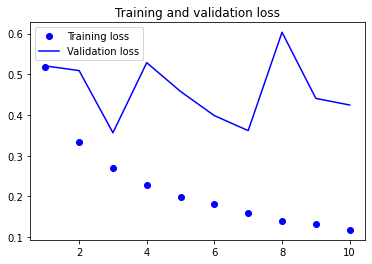

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

같은 기법을 이전 절의 LSTM IMDB 예제에 적용해 보죠:

In [27]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# 특성으로 사용할 단어의 수
max_features = 10000
# 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
maxlen = 500

# 데이터 로드
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 시퀀스를 뒤집습니다
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# 시퀀스에 패딩을 추가합니다
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

Epoch 1/10
157/157 [==============================] - 9s 49ms/step - loss: 0.6048 - acc: 0.6606 - val_loss: 0.3763 - val_acc: 0.8566
Epoch 2/10
157/157 [==============================] - 7s 47ms/step - loss: 0.3168 - acc: 0.8772 - val_loss: 0.3478 - val_acc: 0.8558
Epoch 3/10
157/157 [==============================] - 7s 47ms/step - loss: 0.2472 - acc: 0.9093 - val_loss: 0.4395 - val_acc: 0.8390
Epoch 4/10
157/157 [==============================] - 7s 47ms/step - loss: 0.2114 - acc: 0.9215 - val_loss: 0.4148 - val_acc: 0.8328
Epoch 5/10
157/157 [==============================] - 7s 47ms/step - loss: 0.1793 - acc: 0.9392 - val_loss: 0.4660 - val_acc: 0.8268
Epoch 6/10
157/157 [==============================] - 7s 47ms/step - loss: 0.1600 - acc: 0.9478 - val_loss: 0.3826 - val_acc: 0.8790
Epoch 7/10
157/157 [==============================] - 7s 46ms/step - loss: 0.1412 - acc: 0.9520 - val_loss: 0.4571 - val_acc: 0.8604
Epoch 8/10
157/157 [==============================] - 7s 46ms/step - 

In [28]:
from keras import backend as K
K.clear_session()

In [29]:
# 코드 6-43 양방향 LSTM을 훈련하고 평가하기
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 11s 51ms/step - loss: 0.6476 - acc: 0.6245 - val_loss: 0.4708 - val_acc: 0.7808
Epoch 2/10
157/157 [==============================] - 7s 46ms/step - loss: 0.4372 - acc: 0.8203 - val_loss: 0.6854 - val_acc: 0.7566
Epoch 3/10
157/157 [==============================] - 7s 46ms/step - loss: 0.2742 - acc: 0.9030 - val_loss: 0.3003 - val_acc: 0.8894
Epoch 4/10
157/157 [==============================] - 7s 47ms/step - loss: 0.2336 - acc: 0.9200 - val_loss: 0.3412 - val_acc: 0.8816
Epoch 5/10
157/157 [==============================] - 7s 47ms/step - loss: 0.1990 - acc: 0.9311 - val_loss: 0.3075 - val_acc: 0.8908
Epoch 6/10
157/157 [==============================] - 7s 47ms/step - loss: 0.1825 - acc: 0.9359 - val_loss: 0.6830 - val_acc: 0.7784
Epoch 7/10
157/157 [==============================] - 7s 46ms/step - loss: 0.1802 - acc: 0.9384 - val_loss: 0.3825 - val_acc: 0.8712
Epoch 8/10
157/157 [==============================] - 7s 46ms/step -

여기서는 88%정도의 검증 정확도를 가지며, 이전 절에 사용한 일반 LSTM보다 성능이 조금 더 높습니다. 하지만 모델 파라미터가 많아 보다 빨리 과대적합됩니다. 이제 이를 이용해 원 문제인 온도 예측 문제에 적용합니다.

In [ ]:
# 코드 6-44 양방향 GRU 훈련하기
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
500/500 [==============================] - 24s 43ms/step - loss: 0.3316 - val_loss: 0.2771
Epoch 2/40
500/500 [==============================] - 21s 42ms/step - loss: 0.2807 - val_loss: 0.2653
Epoch 3/40
500/500 [==============================] - 21s 42ms/step - loss: 0.2719 - val_loss: 0.2685
Epoch 4/40
500/500 [==============================] - 21s 42ms/step - loss: 0.2659 - val_loss: 0.2638
Epoch 5/40
500/500 [==============================] - 21s 42ms/step - loss: 0.2602 - val_loss: 0.2663
Epoch 6/40
500/500 [==============================] - 21s 42ms/step - loss: 0.2567 - val_loss: 0.2718
Epoch 7/40
500/500 [==============================] - 21s 42ms/step - loss: 0.2494 - val_loss: 0.2643
Epoch 8/40
500/500 [==============================] - 21s 42ms/step - loss: 0.2448 - val_loss: 0.2709
Epoch 9/40
500/500 [==============================] - 21s 43ms/step - loss: 0.2431 - val_loss: 0.2707
Epoch 10/40
500/500 [==============================] - 21s 42ms/step - loss: 0.231

비슷한 수준의 결과를 내는 것을 알 수 있습니다. 왜냐면 여기서는 역방향 GRU가 좋은 성능을 내지 못하기 때문입니다.
